In [21]:
import matplotlib.pyplot as plt

import numpy as np #importa a biblioteca usada para trabalhar com vetores e matrizes
import pandas as pd #importa a biblioteca usada para trabalhar com dataframes
import util
import scipy
import scipy.optimize
from numba import jit, njit
from scipy.sparse import bsr_matrix
from scipy.linalg.blas import sgemm
import cProfile
import cupy as cp

#importa o arquivo e extrai as features
Xfeatures, Y = util.extract_features('datasets/ARCHEAGE.csv')

['lol' 'atleast' 'csgo' 'archeag' 'keep']


In [22]:
# parametros a serem utilizados neste exercicio
input_layer_size  = Xfeatures.shape[1]  # 20x20 dimensao das imagens de entrada
hidden_layer_size = 500   # 25 neuronios na camada oculta
num_labels = 2          # 10 rotulos, de 1 a 10  
                         #  (observe que a classe "0" recebe o rotulo 10)
    
print('\nCarregando parametros salvos da rede neural...\n')

# carregando os pesos da camada 1
Theta1 = np.random.rand(hidden_layer_size, input_layer_size+1)*np.sqrt(1/(input_layer_size+hidden_layer_size))

# carregando os pesos da camada 2
Theta2 = np.random.rand(num_labels, hidden_layer_size+1)*np.sqrt(1/(hidden_layer_size+num_labels))

# concatena os pesos em um único vetor
nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])

print('Pesos carregados com sucesso!')
print(Theta1.shape)
print(Theta2.shape)
print(nn_params.shape)


Carregando parametros salvos da rede neural...

Pesos carregados com sucesso!
(500, 2244)
(2, 501)
(1123002,)


In [23]:
#@njit
def sigmoid(z):
    """
    Calcula a função sigmoidal  
    """

    z = 1/(1+np.exp(-z))
    
    return z

In [24]:
def inicializaPesosAleatorios(L_in, L_out, randomSeed = None):
    '''
    Inicializa aleatoriamente os pesos de uma camada usando 
    L_in (conexoes de entrada) e L_out (conexoes de saida).

    W sera definido como uma matriz de dimensoes [L_out, 1 + L_in]
    visto que devera armazenar os termos para "bias".
    
    randomSeed: indica a semente para o gerador aleatorio
    '''

    epsilon_init = 0.12
    
    # se for fornecida uma semente para o gerador aleatorio
    if randomSeed is not None:
        W = np.random.RandomState(randomSeed).rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
        
    # se nao for fornecida uma semente para o gerador aleatorio
    else:
        W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
        
    return W


print('\nInicializando parametros da rede neural...\n')
    
#initial_Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
#initial_Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)

# junta os pesos iniciais em um unico vetor
#initial_rna_params = np.concatenate([np.ravel(initial_Theta1), np.ravel(initial_Theta2)])
initial_rna_params = nn_params


Inicializando parametros da rede neural...



In [25]:
#@njit
def sigmoidGradient(z):
    '''
    Retorna o gradiente da funcao sigmoidal para z 
    
    Calcula o gradiente da funcao sigmoidal
    para z. A funcao deve funcionar independente se z for matriz ou vetor.
    Nestes casos,  o gradiente deve ser calculado para cada elemento.
    '''
    
    g = np.zeros(z.shape)

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Instrucoes: Calcula o gradiente da funcao sigmoidal para 
    #           cada valor de z (seja z matriz, escalar ou vetor).
    #

    g = sigmoid(z) * (1 - sigmoid(z))

    ##########################################################################

    return g

In [26]:
def l2a(Y, num_labels):
    n = len(Y)
    y = np.zeros((n, num_labels))
    y[np.arange(n), Y] = 1
    return y

def funcaoCusto_backp_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, Y, vLambda):
    '''
    Implementa a funcao de custo para a rede neural com tres camadas
    voltada para tarefa de classificacao
    
    Calcula o custo e gradiente da rede neural. 
    Os parametros da rede neural sao colocados no vetor nn_params
    e precisam ser transformados de volta nas matrizes de peso.
    
    input_layer_size - tamanho da camada de entrada
    hidden_layer_size - tamanho da camada oculta
    num_labels - numero de classes possiveis
    lambda - parametro de regularizacao
    
    O vetor grad de retorno contem todas as derivadas parciais
    da rede neural.
    '''

    # Extrai os parametros de nn_params e alimenta as variaveis Theta1 e Theta2.
    Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
    Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

    # Qtde de amostras
    m = X.shape[0]
         
    # As variaveis a seguir precisam ser retornadas corretamente
    J = 0;
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Instrucoes: Voce deve completar o codigo a partir daqui 
    #               acompanhando os seguintes passos.
    #
    # (1): Lembre-se de transformar os rotulos Y em vetores com 10 posicoes,
    #         onde tera zero em todas posicoes exceto na posicao do rotulo
    #
    # (2): Execute a etapa de feedforward e coloque o custo na variavel J.
    #
    # (3): Implemente o algoritmo de backpropagation para calcular 
    #      os gradientes e alimentar as variaveis Theta1_grad e Theta2_grad.
    #
    # (4): Implemente a regularização na função de custo e gradiente.
    #
    
    a1 = np.vstack([np.ones(X.T.shape[1]), X.T])
    z2 = np.matmul(Theta1, a1)
    a2 = np.vstack([np.ones(z2.shape[1]), sigmoid(z2)])
    a2 = np.array(a2)
    z3 = np.matmul(Theta2, a2)
    a3 = sigmoid(z3)
    
    reg = vLambda / (2*m) * (np.sum(Theta1[:,1:] ** 2) + np.sum(Theta2[:,1:] ** 2))
    J = 1/m * np.sum(np.sum(-Y * np.log(a3.T) - (1 - Y) * np.log(1 - a3.T))) + reg

    d3 = a3 - Y.T
    d2 = np.multiply(np.matmul(Theta2[:,1:].T, d3), sigmoidGradient(z2))

    Theta1_grad = 1 / m * np.matmul(d2, a1.T)
    Theta2_grad = 1 / m * np.matmul(d3, a2.T)

    reg1 = (vLambda / m) * Theta1
    reg1[:,0] = 0
    reg2 = (vLambda / m) * Theta2
    reg2[:,0] = 0
    
    Theta1_grad = Theta1_grad + reg1
    Theta2_grad = Theta2_grad + reg2

    ##########################################################################

    # Junta os gradientes
    grad = np.concatenate([np.ravel(Theta1_grad), np.ravel(Theta2_grad)])

    return J, grad




# Parametro de regularizacao dos pesos.
vLambda = 3;

print('\n\nChecando a funcao de custo (c/ regularizacao) ... \n')

Yl = l2a(Y, num_labels)

cProfile.run('funcaoCusto_backp_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, Xfeatures, Yl, vLambda)')
J, grad = funcaoCusto_backp_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, Xfeatures, Yl, vLambda)

print('Custo com os parametros (carregados do arquivo): %1.6f' %J)



Checando a funcao de custo (c/ regularizacao) ... 

         86 function calls in 0.423 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.116    0.029    0.116    0.029 <ipython-input-23-a108a933bf09>:2(sigmoid)
        1    0.016    0.016    0.095    0.095 <ipython-input-25-2298d1932d21>:2(sigmoidGradient)
        1    0.049    0.049    0.408    0.408 <ipython-input-26-e21933449eec>:7(funcaoCusto_backp_reg)
        1    0.015    0.015    0.423    0.423 <string>:1(<module>)
        4    0.000    0.000    0.002    0.001 _methods.py:31(_sum)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1427(ravel)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:163(reshape)
        4    0.000    0.000    0.002    0.001 fromnumeric.py:1778(sum)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:50(_wrapfunc)
        2    0.000    0.000    0.000    0.000 numeric.py:146(ones)
        6    0.0

In [8]:
print('\nTreinando a rede neural.......')
print('.......(Aguarde, pois esse processo por ser um pouco demorado.)\n')

# Apos ter completado toda a tarefa, mude o parametro MaxIter para
# um valor maior e verifique como isso afeta o treinamento.
MaxIter = 500

# Voce tambem pode testar valores diferentes para lambda.
vLambda = 1

# Minimiza a funcao de custo
result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, Xfeatures, Yl, vLambda),  
                method='TNC', jac=True, options={'maxiter': MaxIter})

# Coleta os pesos retornados pela função de minimização
nn_params = result.x

# Obtem Theta1 e Theta2 back a partir de rna_params
Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

print(result)


Treinando a rede neural.......
.......(Aguarde, pois esse processo por ser um pouco demorado.)

     fun: 1.2087078914218636
     jac: array([ 1.43074736e-07,  1.34008481e-08, -1.07373237e-09, ...,
        5.52353467e-06,  1.91853474e-06,  9.42686142e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 500
     nit: 49
  status: 3
 success: False
       x: array([-4.31080562e-02,  1.34008481e-07, -1.07373237e-08, ...,
       -7.00591017e-02,  7.23071839e-02, -1.88920047e-02])


In [27]:
@jit
def predicao(Theta1, Theta2, X):
    '''
    Prediz o rotulo de uma amostra apresentada a rede neural
    
    Prediz o rotulo de X ao utilizar
    os pesos treinados na rede neural (Theta1, Theta2)
    '''
    
    m = X.shape[0] # número de amostras
    num_labels = Theta2.shape[0]
    
    p = np.zeros(m)
    
    a1 = np.zeros((m,m+1))

    a1 = np.hstack( [np.ones([m,1]),X] )
    h1 = sigmoid( np.dot(a1,Theta1.T) )
    
    a2 = np.hstack( [np.ones([m,1]),h1] ) 
    h2 = sigmoid( cp.dot(a2,Theta2.T) )
    
    p = np.argmax(h2,axis=1)
    #p = p+1
    
    return p
    

pred = predicao(Theta1, Theta2, Xfeatures)
print(pred[:5])
print(Y[:5])

print('\nAcuracia no conjunto de treinamento: %f\n'%( np.mean( pred == Y ) * 100) )

<ipython-input-27-a167cad4ba3a>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "predicao" failed type inference due to: Untyped global name 'sigmoid': cannot determine Numba type of <class 'function'>

File "<ipython-input-27-a167cad4ba3a>", line 18:
def predicao(Theta1, Theta2, X):
    <source elided>
    a1 = np.hstack( [np.ones([m,1]),X] )
    h1 = sigmoid( np.dot(a1,Theta1.T) )
    ^

  @jit


[1 1 1 1 1]
[1 0 0 1 0]

Acuracia no conjunto de treinamento: 42.142026



D:\Programs\Anaconda3\lib\site-packages\numba\compiler.py:725: NumbaWarning: Function "predicao" was compiled in object mode without forceobj=True.

File "<ipython-input-27-a167cad4ba3a>", line 2:
@jit
def predicao(Theta1, Theta2, X):
^

  self.func_ir.loc))
D:\Programs\Anaconda3\lib\site-packages\numba\compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-27-a167cad4ba3a>", line 2:
@jit
def predicao(Theta1, Theta2, X):
^

  warnings.warn(errors.NumbaDeprecationWarning(msg, self.func_ir.loc))


In [10]:
pd.DataFrame(Theta1).to_csv('pesos_Theta1.csv', index=False)
pd.DataFrame(Theta2).to_csv('pesos_Theta2.csv', index=False)

In [19]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
Xk, Yk = Xfeatures[idx_perm, :], Y[idx_perm]

# define a porcentagem de dados que irao compor o conjunto de treinamento
pTrain = 0.8

# obtem os indices dos dados da particao de treinamento e da particao de teste
train_index, test_index = util.stratified_holdOut(Yk, pTrain)

X_train, X_test = Xk[train_index, :], Xk[test_index, :];
Y_train, Y_test = Yk[train_index], Yk[test_index];

train_index, val_index = util.stratified_holdOut(Y_train, pTrain)

X_train_v, X_val = X_train[train_index, :], X_train[val_index, :]
Y_train_v, Y_val = Y_train[train_index], Y_train[val_index]

print('Numero de dados de validação: %d' %(X_val.shape[0]))

Numero de dados de validação: 275


In [13]:
classes = [0,1]
def gridSearch(X, Y, Xval, Yval):
    """
    Retorna o melhor valor para os parametros lamba da regularizacao da Regressao Logistica.
    
    Parametros
    ----------
    X : matriz com os dados de treinamento
    
    Y : vetor com as classes dos dados de treinamento
    
    Xval : matriz com os dados de validacao
    
    Yval : vetor com as classes dos dados de validacao
    
    Retorno
    -------
    bestReg: o melhor valor para o parametro de regularizacao
    
    """
    
    # inicializa a variável que deverá ser retornada pela função
    bestReg = -100
    
    # Configura o numero de interacaoes da regressao logistica
    iteracoes = 500
    
    # valores que deverao ser testados para o parametro de regularizacao 
    reg = [0,0.5,1,10,50,100];
        
    ########################## COMPLETE O CÓDIGO AQUI  ###############################
    # Instrucoes: Complete esta função para retornar os melhores valores do parametro
    #             de regularizacao da regressao Logistica. 
    #
    #             Você pode calcular o desempenho do classificador atraves da funcao
    #             relatorioDesempenho() criada anteriormente. Use a acuracia para decidir
    #             o melhor parametro.            
    #
    
    perf = []

    '''
    def regmax(i):
        result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, X, Y, i),  
                method='L-BFGS-B', jac=True, options={'maxiter': MaxIter})

        # Coleta os pesos retornados pela função de minimização
        nn_params = result.x

        # Obtem Theta1 e Theta2 back a partir de rna_params
        Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
        Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

        # classifica os dados de teste
        Y_pred = predicao(Theta1, Theta2, X_val)

        # Compute confusion matrix
        cm = util.get_confusionMatrix(Y_val, Y_pred, classes)
        results = util.relatorioDesempenho(cm, [0,1])
        return results['acuracia']
    
    vregmax = np.vectorize(regmax, otypes=['float'])
    perf = vregmax(reg)
    '''

    for i in reg:
        result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, X, Y, i),  
                method='L-BFGS-B', jac=True, options={'maxiter': MaxIter})

        # Coleta os pesos retornados pela função de minimização
        nn_params = result.x

        # Obtem Theta1 e Theta2 back a partir de rna_params
        Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
        Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

        # classifica os dados de teste
        Y_pred = predicao(Theta1, Theta2, X_val)

        # Compute confusion matrix
        cm = util.get_confusionMatrix(Y_val, Y_pred, classes)
        results = util.relatorioDesempenho(cm, [0,1])
        return results['acuracia']
        perf.append(results['acuracia'])
        
    bestReg = reg[np.argmax(perf)]

    ################################################################################## 

    return bestReg


%timeit
bestLambda = gridSearch(X_train_v, l2a(Y_train_v, num_labels), X_val, Y_val)

C:\Users\Gabriel\Documents\UFSCar\BCC7\AM\AM-2019-1\util.py:271: RuntimeWarning: invalid value encountered in true_divide
  fmedida = 2 * (precisao * revocacao) / (precisao + revocacao)
C:\Users\Gabriel\Documents\UFSCar\BCC7\AM\AM-2019-1\util.py:275: RuntimeWarning: invalid value encountered in double_scalars
  fmedida_macroAverage = 2 * (precisao_macroAverage * revocacao_macroAverage) / (precisao_macroAverage + revocacao_macroAverage)
C:\Users\Gabriel\Documents\UFSCar\BCC7\AM\AM-2019-1\util.py:279: RuntimeWarning: invalid value encountered in double_scalars
  fmedida_microAverage = 2 * (precisao_microAverage * revocacao_microAverage) / (precisao_microAverage + revocacao_microAverage)


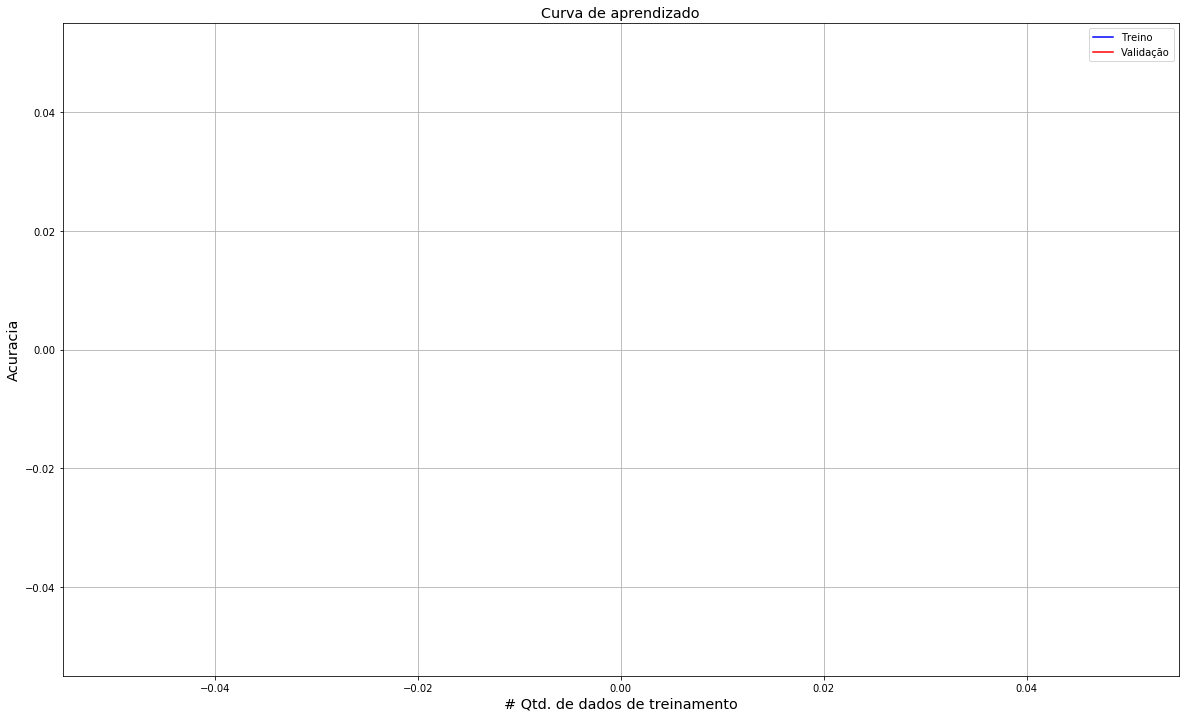

In [15]:
def curva_aprendizado(X, Y, Xval, Yval, Yl):
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
  
    """

    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # inicializa o parametro de regularizacao da regressao logistica
    lambda_reg = 1
        
    # Configura o numero de interacaoes da regressao logistica
    iteracoes = 500
        
    ########################## COMPLETE O CÓDIGO AQUI  ###############################
    #  Instrucoes: Complete o codigo para gerar o gráfico da curva de aprendizado.
    #           Comece o treinamento com as primeiras 10 amostras da base de dados de 
    #           treinamento e calcule a acuracia do classificador tanto nos dados de
    #           treinamento já apresentados, quando na base de validacao. 
    #           Depois disso, adicione mais um dado para treinamento e calcule novamente 
    #           o desempenho. Continue adicionando um dado por vez ate todos os dados de 
    #           treinamento serem usados. Nas listas perf_train e perf_val, guarde a acuracia 
    #           obtida nos dados de treinamento e na base de validacao a cada nova adicao de 
    #           dados para treinamento.
    
    for i in np.arange(9, len(X) - 1):
        print(i)
        # Apos ter completado toda a tarefa, mude o parametro MaxIter para
        # um valor maior e verifique como isso afeta o treinamento.
        MaxIter = 500

        # Voce tambem pode testar valores diferentes para lambda.
        vLambda = bestLambda

        # Minimiza a funcao de custo
        result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, X[:i], Yl[:i], vLambda),  
                method='L-BFGS-B', jac=True, options={'maxiter': MaxIter})

        # Coleta os pesos retornados pela função de minimização
        nn_params = result.x

        # Obtem Theta1 e Theta2 back a partir de rna_params
        Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
        Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )
        
        Theta1 = cp.array(Theta1)
        Theta2 = cp.array(Theta2)

        
        # Teste
        p = predicao(Theta1, Theta2, X[:i])
        cm = util.get_confusionMatrix(cp.asnumpy(Y[:i]), p, [0,1])
        results = util.relatorioDesempenho(cm, [0,1])
        perf_train.append(results['acuracia'])
        # Validação
        p = predicao(Theta1, Theta2, Xval[:i])
        cm = util.get_confusionMatrix(cp.asnumpy(Yval[:i]), p, [0,1])
        results = util.relatorioDesempenho(cm, [0,1])
        perf_val.append(results['acuracia'])

    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()
    
curva_aprendizado(X_train_v, cp.array(Y_train_v), X_val, Y_val, cp.array(Yl))

In [16]:
print(bestLambda)

0.0


In [ ]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
Xk, Yk = Xfeatures[idx_perm, :], Y[idx_perm]

nFolds = 10
classes = [0,1]
iteracoes=1000
folds = util.stratified_kfolds(Yk, nFolds, classes) 

k=1
resultados=[]
for train_index, test_index in folds:
    print('\n-----------\n%d-fold: \n-----------\n' % (k) )

    # se train_index ou test_index forem vazios, interrompe o laco de repeticao
    if len(train_index)==0 or len(test_index)==0: 
        print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
        break
        
    totalFold = len(train_index)+len(test_index)

    X_train, X_test = Xk[train_index, :], Xk[test_index, :];
    Y_train, Y_test = Yk[train_index], Yk[test_index];
    
    # separa os dados de treinamento em treinamento e validacao
    pTrain = 0.8
    train_index_v, val_index = util.stratified_holdOut(Y_train, pTrain)

    # Apos ter completado toda a tarefa, mude o parametro MaxIter para
    # um valor maior e verifique como isso afeta o treinamento.
    MaxIter = 500

    # Voce tambem pode testar valores diferentes para lambda.
    vLambda = 1
    
    # chama a função que faz a busca em grade
    #vLambda = gridSearch(X_train_v, Y_train_v, X_val, Y_val)
    vLambda = bestLambda

    # Minimiza a funcao de custo
    result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, Xfeatures, Yl, vLambda),  
                method='TNC', jac=True, options={'maxiter': MaxIter})

    # Coleta os pesos retornados pela função de minimização
    nn_params = result.x

    # Obtem Theta1 e Theta2 back a partir de rna_params
    Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
    Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

    # classifica os dados de teste
    Y_pred = predicao(Theta1, Theta2, X_test)

    # Compute confusion matrix
    cm = util.get_confusionMatrix(Y_test, Y_pred, classes)

    # Gera o relatório de desempenho
    #print('\n\n\n\t'+"="*50+'\n\tMelhor parametro de regularizacao: %1.6f' %bestRegularization)
    print('\n\tResultado no fold atual usando o melhor parametro encontrado:')
    auxResults = util.relatorioDesempenho(cm, classes, imprimeRelatorio=True)

    # adiciona os resultados do fold atual na lista de resultados
    resultados.append( auxResults ) 
        
    k+=1


-----------
1-fold: 
-----------



D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply



	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.869       0.811      0.839      0
	0.722       0.800      0.759      1
	------------------------------------------------
	0.795       0.806      0.801      Média macro
	0.807       0.807      0.807      Média micro

	Acuracia: 0.807

-----------
2-fold: 
-----------


	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.848       0.840      0.844      0
	0.778       0.789      0.783      1
	------------------------------------------------
	0.813       0.814      0.814      Média macro
	0.819       0.819      0.819      Média micro

	Acuracia: 0.819

-----------
3-fold: 
-----------


	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.848       0.832      0.840      0
	0.764       0.786      0.775      1
	------------------------------------------------
	0.806       

In [ ]:
print('\nResultado final da classificação:')
util.mediaFolds( resultados, classes )